# Image Processing CookBook
## Chapter 10
### Author - Sandipan Dey

### Fashion MNIST Dataset

In [15]:
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

# Function that downloads a specified MNIST data file from zalandoresearch website
def download(filename, source='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_fashion_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_fashion_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

## Load the training set
train_data = load_fashion_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_fashion_mnist_labels('train-labels-idx1-ubyte.gz')
## Load the testing set
test_data = load_fashion_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_fashion_mnist_labels('t10k-labels-idx1-ubyte.gz')
print(train_data.shape)
# (60000, 784) ## 60k 28x28 handwritten digits
print(test_data.shape)
# (10000, 784) ## 10k 2bx28 handwritten digits
print(np.max(train_data))

(60000, 784)
(10000, 784)
255


10


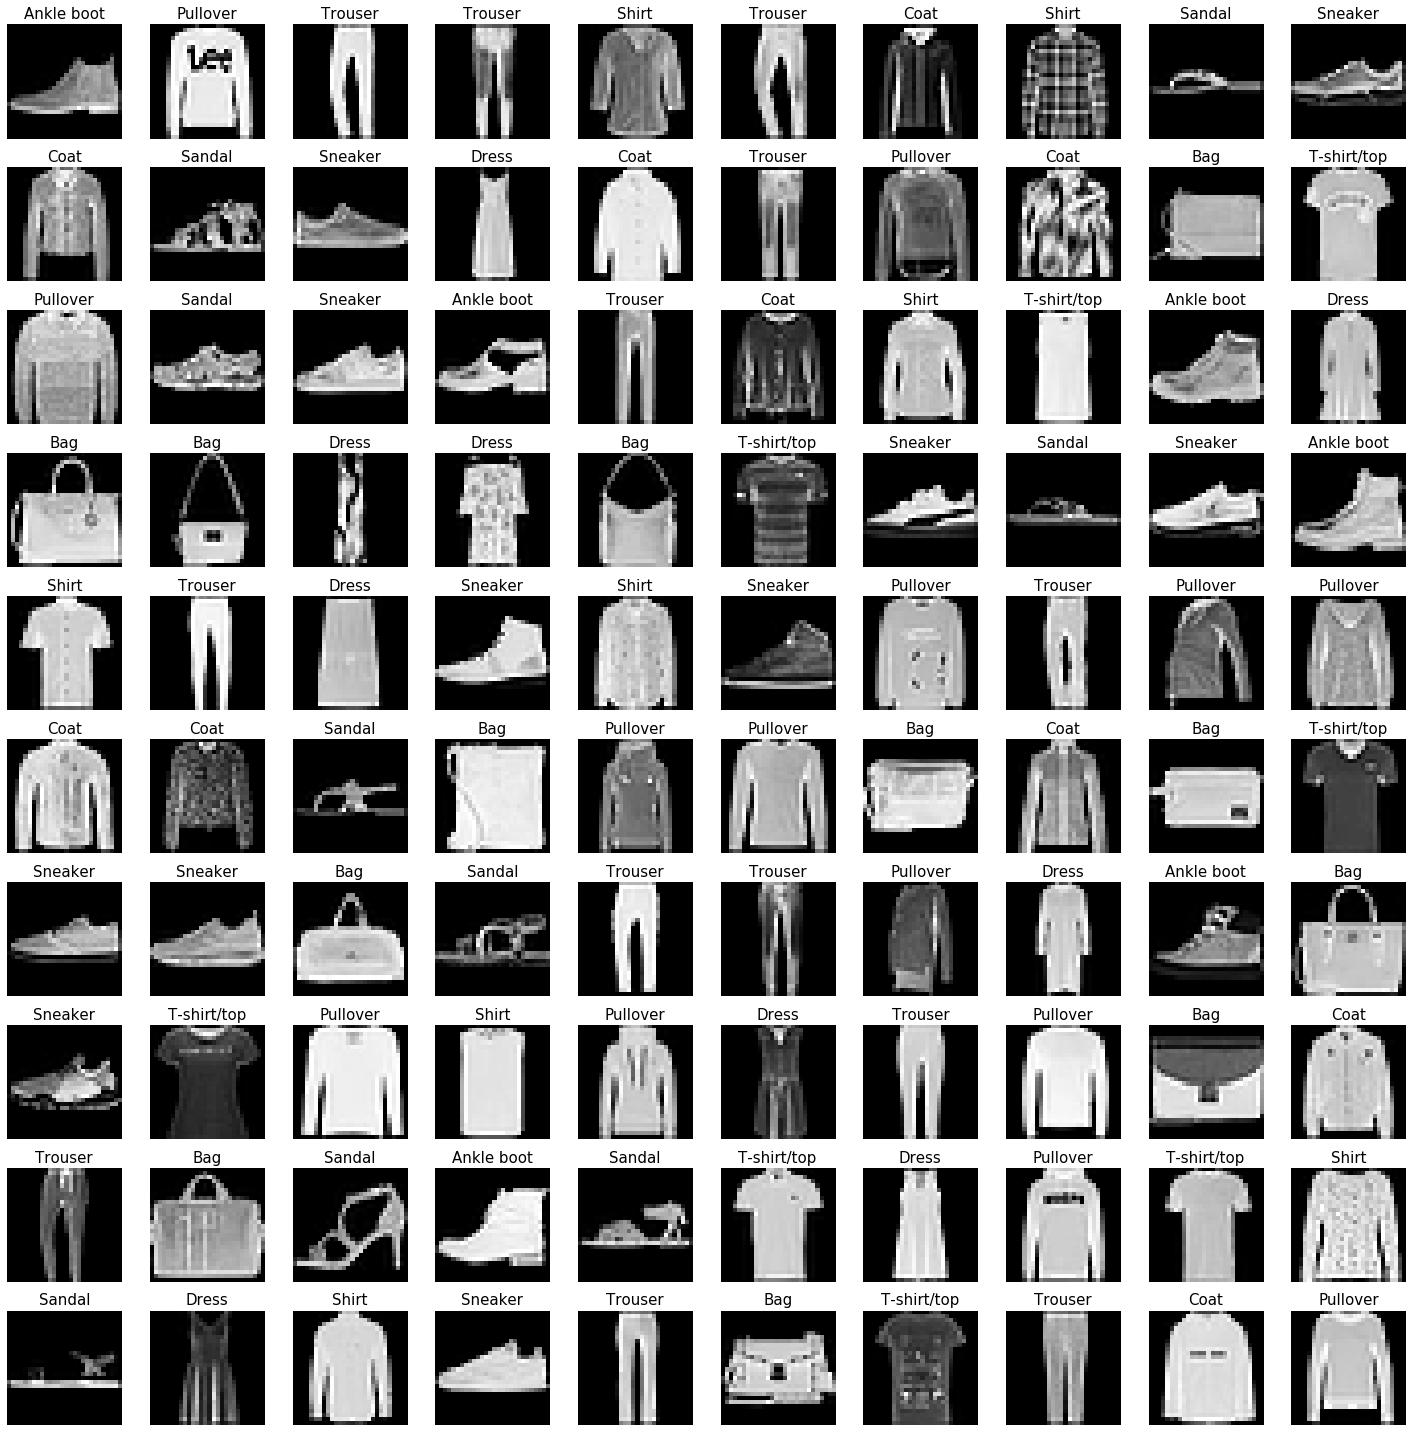

In [16]:
products = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(len(products))
## Define a function that displays an image given its vector representation
def show_image(x, label):
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.title(products[label], size=15)
    plt.axis('off')

plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    show_image(test_data[i,:], test_labels[i])
plt.tight_layout()
plt.show()

In [21]:
# normalize
X_train = np.zeros(train_data.shape)
for i in range(train_data.shape[0]):
    X_train[i,:] = train_data[i,:] / np.max(train_data[i,:])
X_test = np.zeros(test_data.shape)
for i in range(test_data.shape[0]):
    X_test[i,:] = test_data[i,:] / np.max(test_data[i,:])

## Varitaional AutoEncoder for Image Reconstruction / Generation

In [17]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n*n, 512)
        self.fc21 = nn.Linear(512, 32) # mu
        self.fc22 = nn.Linear(512, 32) # sigma
        self.fc3 = nn.Linear(32, 512)
        self.fc4 = nn.Linear(512, n*n)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, n*n))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [24]:
torch.manual_seed(1)

cuda = torch.cuda.is_available()
batch_size = 512 #128
log_interval = 20
epochs = 20
n = 28

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = DataLoader(np.reshape(X_train, (-1, 1, n, n)).astype(np.float32), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(np.reshape(X_test, (-1, 1, n, n)).astype(np.float32), batch_size=batch_size, shuffle=True)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, n*n), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    batch_idx = 0
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        #print(recon_batch.shape, mu.shape, logvar.shape)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
        batch_idx += 1

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return losses

def test(epoch):
    model.eval()
    losses = []
    i = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                N = min(data.size(0), 8)
                comparison = torch.cat([data[:N],
                                      recon_batch.view(batch_size, 1, n, n)[:N]])
                save_image(comparison.cpu(),
                         'images/reconstruction_' + str(epoch) + '.png', nrow=N)
                i += 1

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, epochs + 1):
    train(epoch)[:-1]
    test(epoch)[:-1]
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, n, n),
                   'images/sample_' + str(epoch) + '.png')
torch.save(model, 'models/vae.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.872864
Train Epoch: 1 [10240/60000 (17%)]	Loss: 364.307800
Train Epoch: 1 [20480/60000 (34%)]	Loss: 315.576965
Train Epoch: 1 [30720/60000 (51%)]	Loss: 299.686127
Train Epoch: 1 [40960/60000 (68%)]	Loss: 293.210052
Train Epoch: 1 [51200/60000 (85%)]	Loss: 290.811737
====> Epoch: 1 Average loss: 326.1891
====> Test set loss: 282.2962
Train Epoch: 2 [0/60000 (0%)]	Loss: 275.476410
Train Epoch: 2 [10240/60000 (17%)]	Loss: 276.888550
Train Epoch: 2 [20480/60000 (34%)]	Loss: 270.407104
Train Epoch: 2 [30720/60000 (51%)]	Loss: 271.435394
Train Epoch: 2 [40960/60000 (68%)]	Loss: 274.942444
Train Epoch: 2 [51200/60000 (85%)]	Loss: 267.174683
====> Epoch: 2 Average loss: 273.7068
====> Test set loss: 270.5091
Train Epoch: 3 [0/60000 (0%)]	Loss: 268.763550
Train Epoch: 3 [10240/60000 (17%)]	Loss: 268.228668
Train Epoch: 3 [20480/60000 (34%)]	Loss: 265.624573
Train Epoch: 3 [30720/60000 (51%)]	Loss: 262.081329
Train Epoch: 3 [40960/60000 (68%)]	Loss: 262.05

![](images/vae_recons.png)

![](images/vae_gen.png)

In [4]:
#! pip3.7 install torchviz
import torch
from torchviz import make_dot
cu### Images decoded from the test images encodings with VAEda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
n = 28
model = torch.load('vae.pth')
x = torch.randn(1, 784).to(device)
out = model(x)
make_dot(out)

![](images/vae_model.png)

In [19]:
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc21): Linear(in_features=512, out_features=32, bias=True)
  (fc22): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=784, bias=True)
)


### Bangla MNIST Dataset (Numta)

In [1]:
# download the numta dataset from here: https://www.kaggle.com/BengaliAI/numta/version/4
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pylab as plt
from skimage.transform import resize
#from skimage.filters import threshold_otsu

df = pd.read_csv('../training-a.csv')
print(df.shape)
df.head()

(19702, 7)


,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [ ]:
n = 28
df = pd.read_csv('images/training-e.csv')

X_train = np.zeros((df.shape[0], n*n))

for i in range(df.shape[0]): 
    img = rgb2gray(imread('images/training-e/' + df.iloc[i]['filename'])) 
    if i % 1000 == 0: print(i) 
    X_train[i,:] = np.array([np.ravel(img)])

In [ ]:
from glob import glob

n = 28
test_images = glob('images/testing-e/*.png')
print(len(test_images))

X_test = np.zeros((len(test_images), n*n))

for i in range(len(test_images)): 
    img = rgb2gray(imread(test_images[i])) 
    img = resize(img, (n,n))
    X_test[i,:] = np.array([np.ravel(img)])

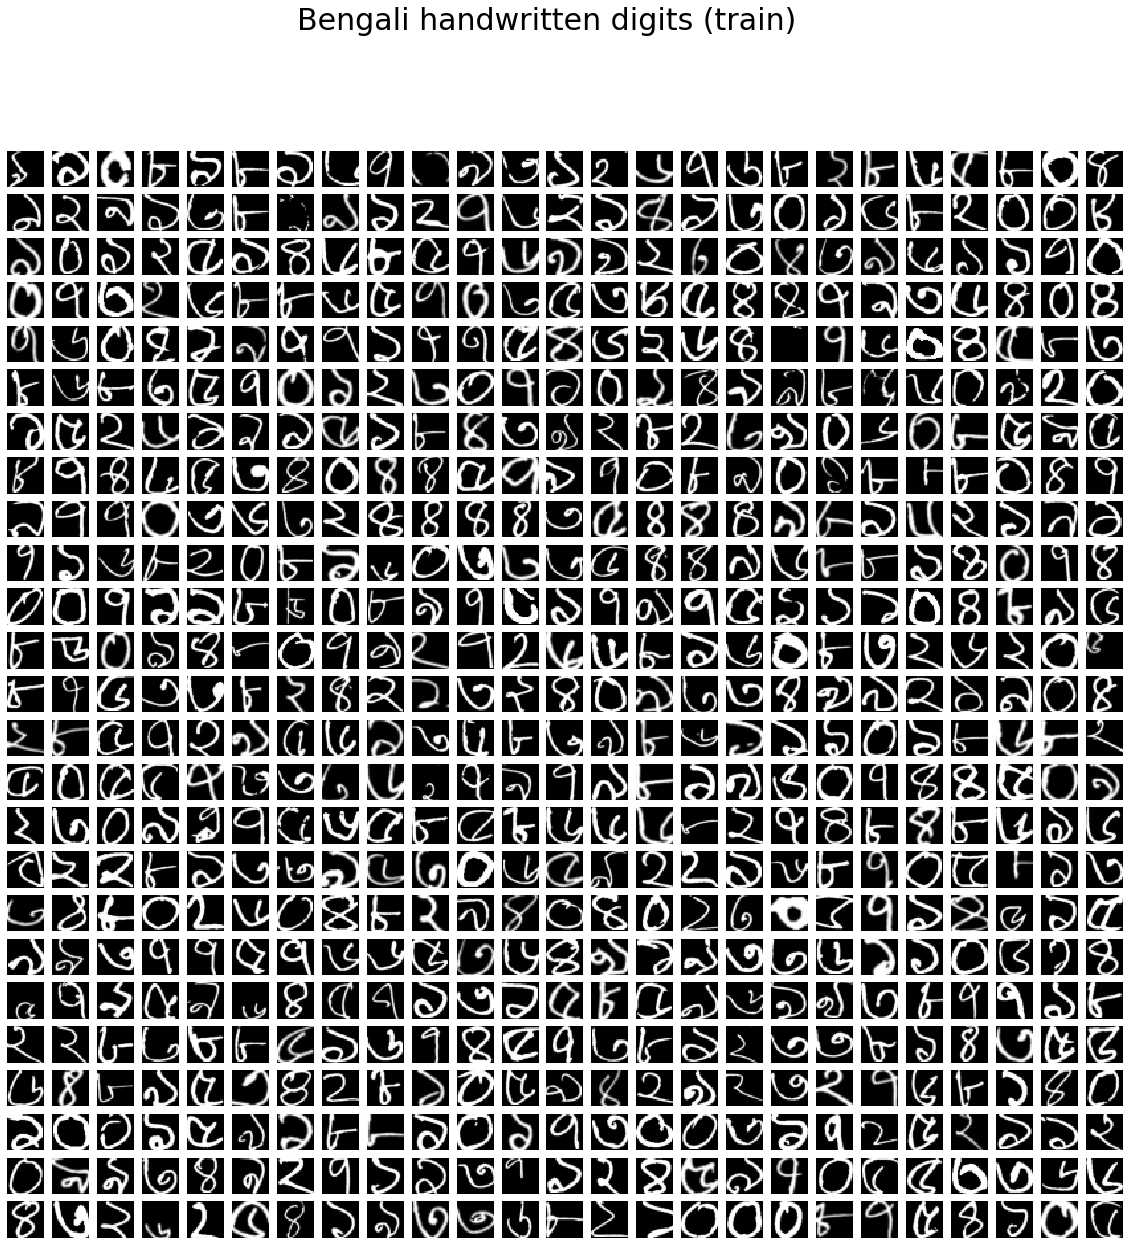

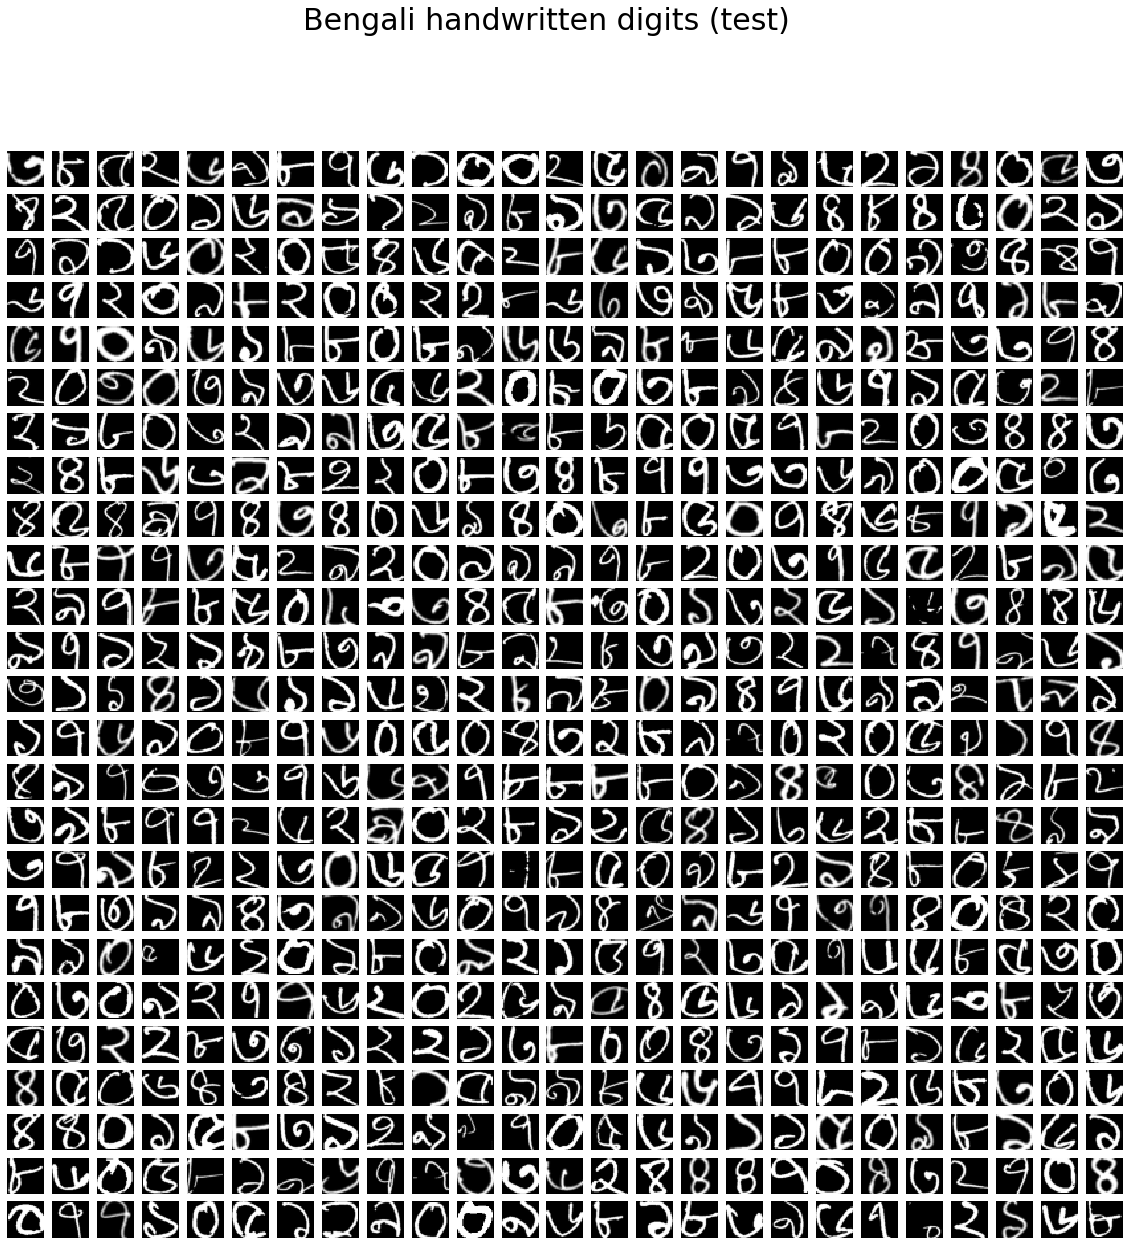

In [8]:
indices = np.random.choice(range(X_train.shape[0]), 625)
plt.figure(figsize=(20,20))
plt.gray()
for i in range(625):
    img = np.reshape(X_train[indices[i],:], (n,n))
    plt.subplot(25,25,i+1)
    plt.imshow(255*img)
    plt.axis('off')
plt.suptitle('Bengali handwritten digits (train)', size=30)
plt.savefig('digits_viz_train.png')
#plt.show()
plt.figure(figsize=(20,20))
plt.gray()
indices = np.random.choice(range(X_test.shape[0]), 625)
for i in range(625):
    img = np.reshape(X_test[indices[i],:], (n,n))
    plt.subplot(25,25,i+1)
    plt.imshow(255*img)
    plt.axis('off')
plt.suptitle('Bengali handwritten digits (test)', size=30)
plt.savefig('digits_viz_test.png')
plt.show()

### Restricted Boltzmann Machine for Image Generation

In [3]:
from scipy.ndimage import convolve
from skimage.transform import resize

def nudge_dataset(X):
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((n, n)), mode='constant', weights=w).ravel()
    
    def crop(x, w):
        return (resize(x.reshape(n, n)[w:n-w, w:n-w], (n,n))).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors] + [np.apply_along_axis(crop, 1, X, 1)])
    return X

n = 28
X_train = nudge_dataset(X_train)
X_test = nudge_dataset(X_test)
print(X_train.shape, X_test.shape)
# (100668, 784) (17820, 784)

(100668, 784) (17820, 784)


-26.263362352012983
-21.413847792572177
-18.099876674903832
-15.782569226879758
-13.931824350115006
-12.33887965788091
-11.060880244685913
-10.01538999915728
-8.981870854566544
-8.233768985961294
-7.632518787674492
-6.94242339932979
-6.420192970237151
-6.126131938798778
-5.656485775400539
-5.30961694088079
-5.103061269382535
-4.795179338019511
-4.474417904306789
-4.290171666798858


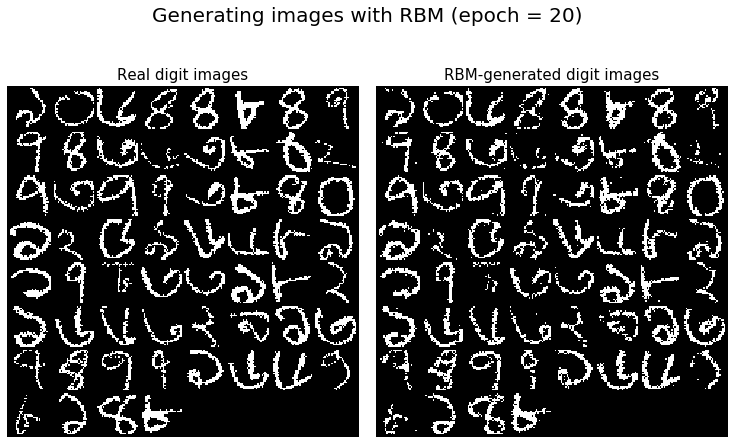

In [10]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
from torch.utils.data import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

def save_image(real_img, gen_img, epoch, show=False):
    plt.figure(figsize=(10,7))
    plt.gray()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
    plt.subplot(121), plt.imshow(np.transpose(real_img.numpy(),(1,2,0))), plt.axis('off'), plt.title('Real digit images', size=15)
    plt.subplot(122), plt.imshow(np.transpose(gen_img.numpy(),(1,2,0))), plt.axis('off'), plt.title('RBM-generated digit images', size=15)
    plt.suptitle('Generating images with RBM (epoch = {})'.format(epoch+1), size=20)
    plt.savefig("./rbm_{:02d}.png".format(epoch)) #imsave
    if show:
        plt.show()
    plt.close()
    
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
    
batch_size = 256 #64
train_loader = DataLoader(np.reshape(X_train, (-1, 28, 28)).astype(np.float32), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(np.reshape(X_test, (-1, 28, 28)).astype(np.float32), batch_size=batch_size, shuffle=True)

rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(), 0.1) #, weight_decay=1e-4)
loss_epoch = []
for epoch in range(20):
    loss_ = []
    for data in train_loader:
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()  
    save_image(make_grid(v.view(60,1,28,28).data), make_grid(v1.view(60,1,28,28).data), epoch)
    mean_loss = np.mean(loss_)
    print(mean_loss) 
    loss_epoch.append(mean_loss)
    
save_image(make_grid(v.view(60,1,28,28).data), make_grid(v1.view(60,1,28,28).data), epoch, True)

In [ ]:
torch.save(rbm, 'rbm.pth')

In [ ]:
#! pip3.7 install torchviz
import torch
from torchviz import make_dot
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
n = 28
model = torch.load('rbm.pth')
x = torch.randn(1, 784).to(device)
out = model(x.cpu())
make_dot(out)

![](images/rbm_model.png)

(500, 784)


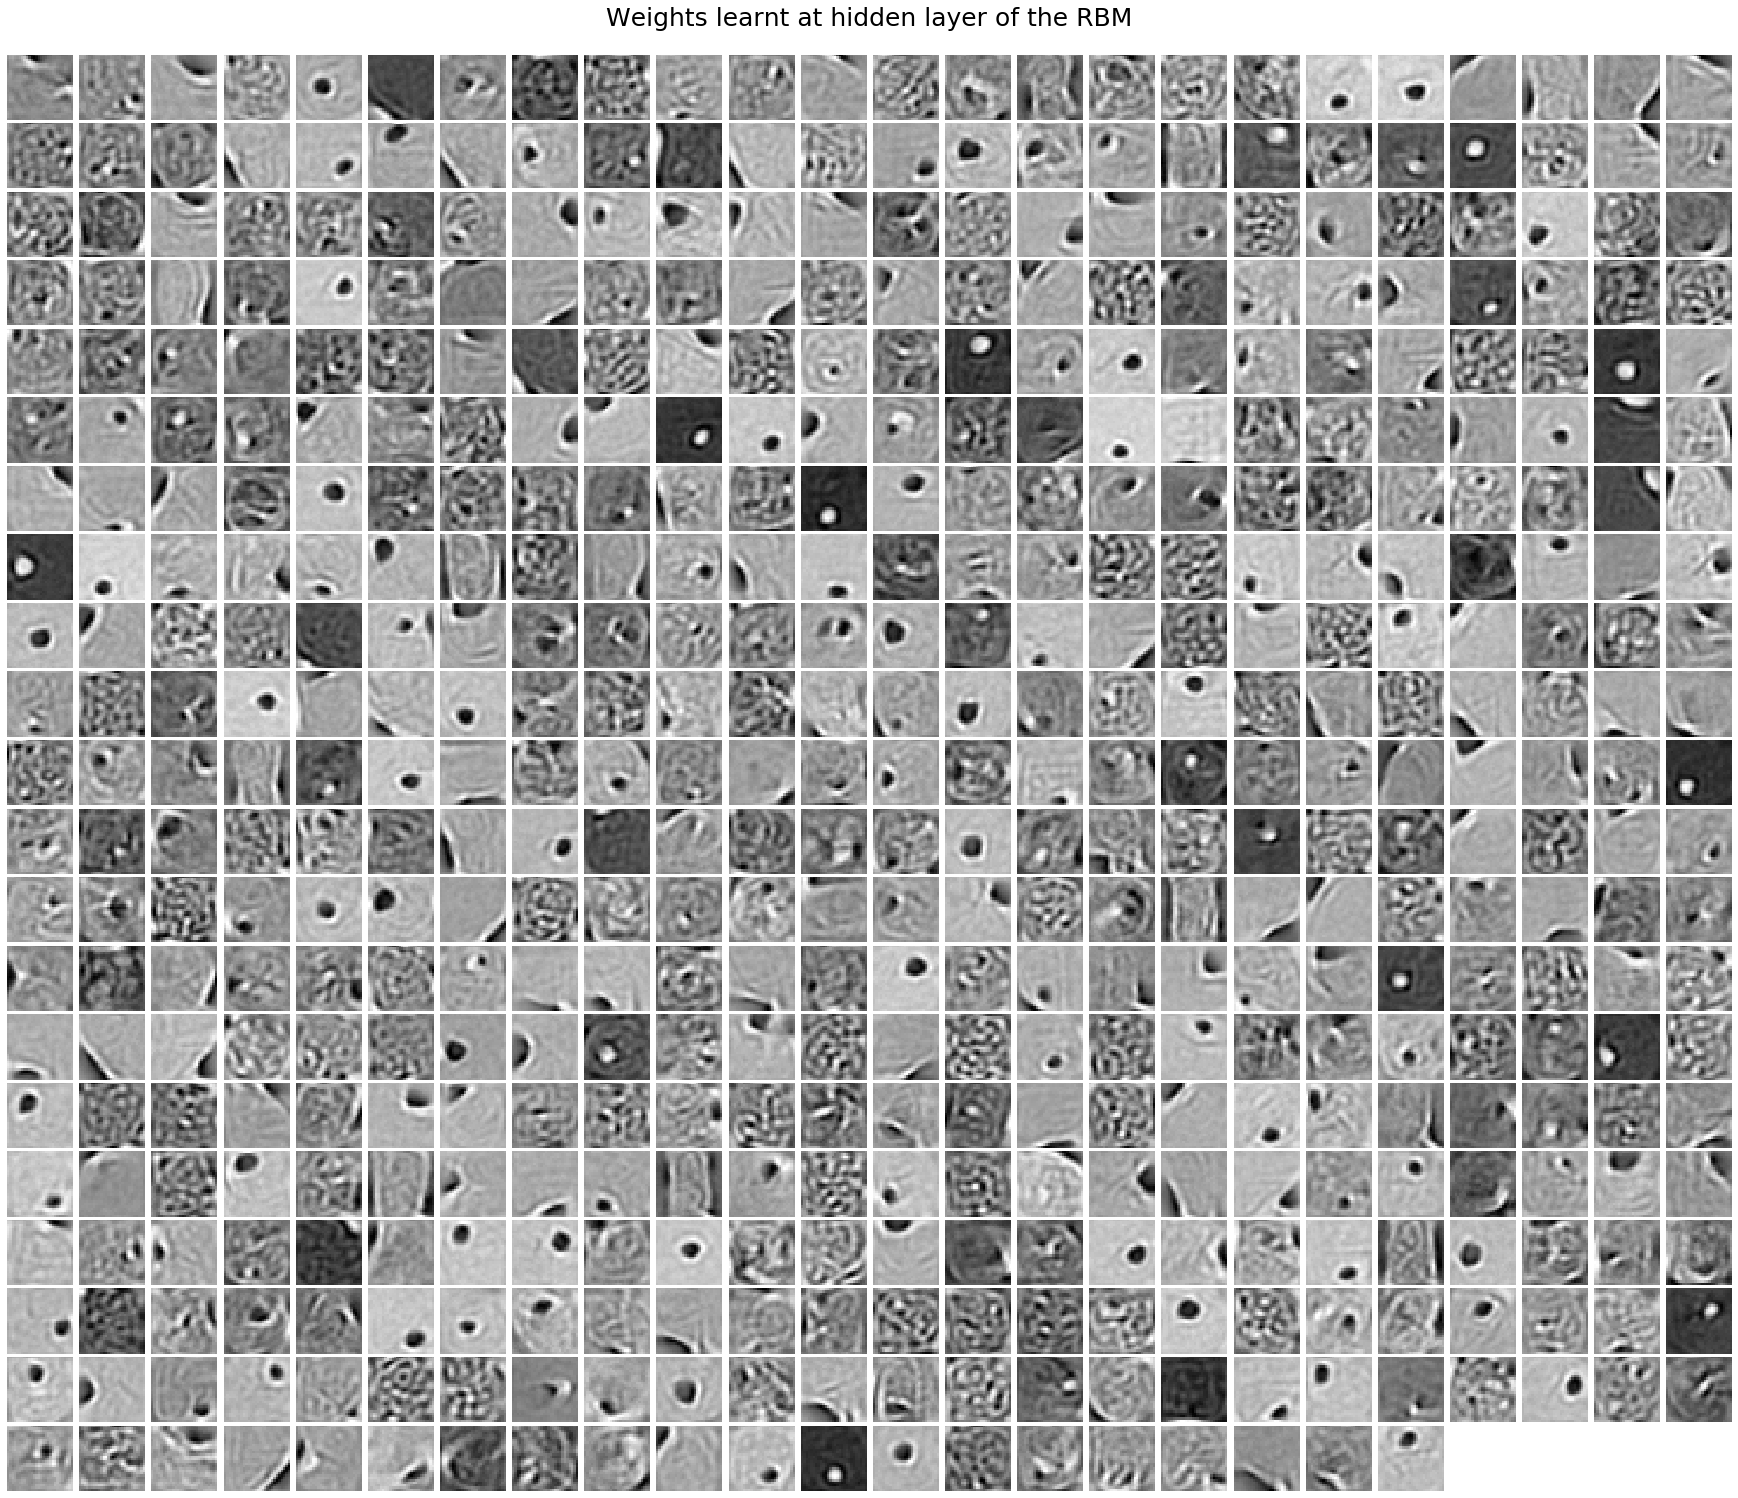

In [14]:
filter = rbm.W.detach().numpy()
print(filter.shape)
plt.figure(figsize=(24,22))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
for i in range(500):
    plt.subplot(22,24,i+1), plt.imshow(np.reshape(filter[i,:], (n,n))), plt.axis('off')
plt.suptitle('Weights learnt at hidden layer of the RBM', size=25)
plt.savefig('rbm_weights.png')